In [1]:
import numpy as np
#import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


sns.set_style("white")

#for normalization + probability density function computation
from scipy import stats
#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform
print("import done")

import done


In [3]:
N = 100
mu_arr = np.array([1, 10])
sigma_arr = np.array([1, 1])
x = np.append(np.random.normal(mu_arr[0], sigma_arr[0], N), 
              np.random.normal(mu_arr[1], sigma_arr[1], N))
x[:10]

array([ 1.96763265,  2.21591344,  0.35345043,  1.13154186,  3.04328685,
       -1.26097364, -1.6349877 ,  0.79430062,  0.43218687,  2.14750615])

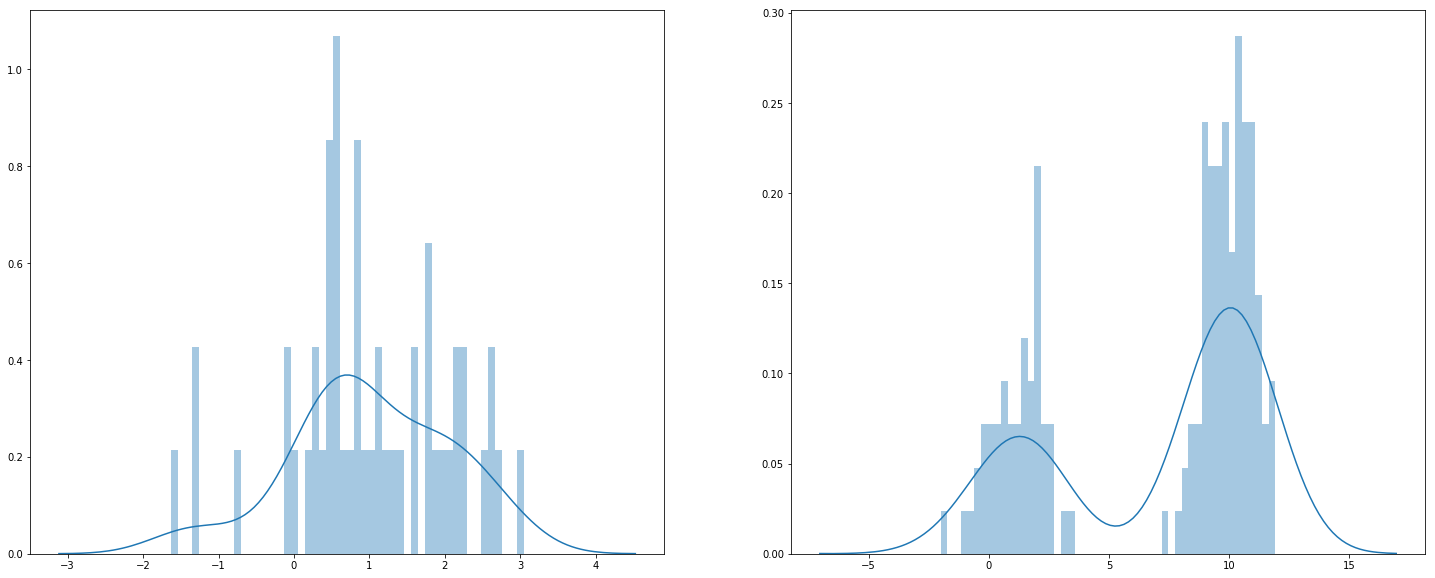

In [26]:
plt.figure(num=2, figsize=(25,10))
plt.subplot(1,2,1)
sns.distplot(x[:50],bins=50,kde=True)
plt.subplot(1,2,2)
sns.distplot(x[50:],bins=50,kde=True)

In [15]:
plt.subplot?

In [31]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
print("done")

done


In [34]:
g1 = Gaussian(0,1)

g2 = Gaussian(0,10)

In [35]:
g1.pdf(0.1),g2.pdf(0.1)

(0.3969525474770118, 0.03989223337860822)

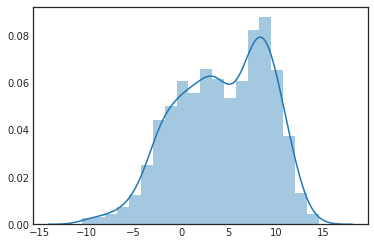

In [38]:
Mean1 = 2  # Input parameter, mean of first normal probability distribution
Standard_dev1 = 4 #@param {type:"number"}
Mean2 = 9 # Input parameter, mean of second normal  probability distribution
Standard_dev2 = 2 #@param {type:"number"}

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data

sns.distplot(data, bins=20, kde=True)

In [127]:
data[1000:].mean()

8.9702899234607

Best single Gaussian: μ = 4.3, σ = 4.8


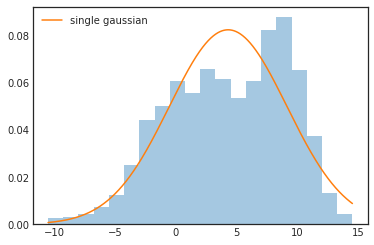

In [41]:
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))
#fit a single gaussian curve to the data
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [130]:
a=stats.norm(best_single.mu, best_single.sigma)

In [132]:
a.pdf(x[4])

0.0007778352073923629

In [98]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(wp1 + wp2) #freshening up self.loglike in the process
            
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
     
        one_den = sum(left)
        two_den = sum(rigt)
        print (one_den,two_den,len(data))

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike
        print (self.loglike)

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")

done


In [64]:
p1 = GaussianMixture_self(data=data)

In [68]:
p1.one

Gaussian(9.69144,  1.0)

In [71]:
for a in p1.Estep():
    print (a)

(0.89604289695146, 0.10395710304853996)
(1.4384050700628526e-16, 0.9999999999999998)
(6.573089437768048e-11, 0.9999999999342691)
(1.0, 1.683793087839978e-61)
(1.0, 7.051604746024227e-51)
(0.9999999999962648, 3.7352886021960126e-12)
(2.2871135711607044e-48, 1.0)
(1.0, 2.972940167782059e-67)
(0.9999999049606231, 9.503937687394395e-08)
(1.0, 5.945973735109829e-45)
(1.0, 3.6932641917962815e-52)
(1.0, 3.184255676377438e-54)
(1.0, 4.1398923421010367e-41)
(0.6269362050458042, 0.3730637949541958)
(1.0, 1.9403004592867692e-21)
(1.0, 9.60583095137442e-27)
(0.9999999999993198, 6.802320949432827e-13)
(1.0, 8.671204238969547e-67)
(0.9999999796064212, 2.0393578765528742e-08)
(1.0, 4.0355107086821524e-30)
(1.0, 3.425161792326319e-37)
(1.9168563178931136e-26, 1.0)
(3.7774082076353593e-20, 1.0)
(1.0, 5.0133554018863615e-130)
(4.991014649010378e-30, 1.0)
(1.0, 3.469300140315555e-73)
(0.9999999995761296, 4.238703866890989e-10)
(1.0, 2.3566231927121865e-42)
(3.45692931968773e-14, 0.9999999999999654)
(1.0,

In [99]:
# See the algorithem in action
n_iterations = 2
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        print("one less")
        pass

(1138.1627253636486, 361.8372746363508, 1500)
 1 Mixture: Gaussian(6.41883, 3.29942), Gaussian(-2.29399, 2.23275), mix=0.759)
-6.10622663544e-15
(1132.919497485575, 367.0805025144255, 1500)
 1 Mixture: Gaussian(6.35, 3.45521), Gaussian(-1.9571, 2.54555), mix=0.755)
-2.17603712827e-14


In [103]:
mix.pdf(data[:1])

0.0446882653361608

In [102]:
log(0.9999999)

-1.0000000494736474e-07

In [80]:
log(1.11) + log(1.11)

0.2087200306484857

In [86]:
def rn():
    for i in range(10):
        yield i
        
        

In [87]:
gen = rn()
zip(*gen)

TypeError: zip argument #1 must support iteration

Computing best model with random restarts...

(468.2124292402239, 1031.7875707597775, 1500)
-2.38697950294e-14
(457.60325585019706, 1042.3967441498035, 1500)
-1.98729921408e-14
(456.715978546495, 1043.2840214535058, 1500)
-1.79856129989e-14
(458.39741771904403, 1041.602582280957, 1500)
-1.64313007645e-14
(460.91739110664724, 1039.0826088933518, 1500)
-2.10942374679e-14
(463.72019909472874, 1036.2798009052703, 1500)
-1.97619698383e-14
(466.58423693074485, 1033.4157630692541, 1500)
-1.79856129989e-14
(469.4056813600872, 1030.5943186399134, 1500)
-2.07611705605e-14
(472.131738429835, 1027.8682615701643, 1500)
-2.10942374679e-14
(474.7356981276363, 1025.264301872364, 1500)
-1.80966353014e-14
(477.2055322433569, 1022.7944677566418, 1500)
-1.9206858326e-14
(479.5377832413478, 1020.462216758653, 1500)
-1.75415237891e-14
(481.73398329287613, 1018.2660167071251, 1500)
-1.87627691162e-14
(483.79848152614045, 1016.2015184738584, 1500)
-2.10942374679e-14
(485.7371188268263, 1014.2628811731763, 150

(515.3101385262697, 984.6898614737299, 1500)
-1.52100554374e-14
(515.310573087324, 984.6894269126778, 1500)
-2.24265050974e-14
(515.3109813393114, 984.6890186606887, 1500)
-1.83186799063e-14
(515.3113648750395, 984.6886351249603, 1500)
-2.00950367457e-14
(515.3117251908815, 984.6882748091191, 1500)
-1.97619698383e-14
(515.3120636926167, 984.6879363073834, 1500)
-2.02060590482e-14
(515.3123817009141, 984.687618299085, 1500)
-2.24265050974e-14
(515.3126804564866, 984.6873195435136, 1500)
-1.7763568394e-14
(515.3129611249321, 984.6870388750683, 1500)
-1.95399252334e-14
(515.3132248012769, 984.6867751987216, 1500)
-1.9206858326e-14
(515.3134725142543, 984.6865274857444, 1500)
-1.9206858326e-14
(515.3137052303163, 984.6862947696839, 1500)
-1.87627691162e-14
(515.3139238574018, 984.6860761425988, 1500)
-1.79856129989e-14
(515.314129248482, 984.685870751518, 1500)
-1.87627691162e-14
(515.3143222048858, 984.6856777951135, 1500)
-1.60982338571e-14
(515.3145034794304, 984.6854965205682, 1500)
-1

(1032.0287101260105, 467.97128987398963, 1500)
-6.32827124036e-15
(1021.494727272248, 478.5052727277522, 1500)
-2.16493489802e-14
(1008.5230819558984, 491.476918044102, 1500)
-2.03170813506e-14
(995.5416895274988, 504.45831047250107, 1500)
-2.14273043753e-14
(982.7193012557645, 517.2806987442353, 1500)
-1.69864122768e-14
(970.0421770643741, 529.9578229356256, 1500)
-1.80966353014e-14
(957.4862793203857, 542.5137206796139, 1500)
-2.12052597703e-14
(945.0346343371646, 554.9653656628351, 1500)
-1.95399252334e-14
(932.6769908518788, 567.3230091481213, 1500)
-1.66533453694e-14
(920.4078688142253, 579.5921311857742, 1500)
-1.72084568817e-14
(908.2250300197913, 591.7749699802092, 1500)
-2.07611705605e-14
(896.1284674793371, 603.8715325206621, 1500)
-2.09832151654e-14
(884.1197766880623, 615.8802233119369, 1500)
-1.93178806285e-14
(872.2017855904355, 627.7982144095646, 1500)
-2.18713935851e-14
(860.3783562305638, 639.6216437694355, 1500)
-1.84297022088e-14
(848.6542984426469, 651.345701557352,

(515.6054660844497, 984.3945339155505, 1500)
-1.83186799063e-14
(515.5880239354844, 984.4119760645159, 1500)
-2.10942374679e-14
(515.5716374286595, 984.4283625713399, 1500)
-2.14273043753e-14
(515.5562426924777, 984.4437573075213, 1500)
-1.82076576039e-14
(515.5417797177995, 984.4582202822004, 1500)
-2.13162820728e-14
(515.5281921245373, 984.4718078754615, 1500)
-2.04281036531e-14
(515.5154269424185, 984.4845730575806, 1500)
-2.33146835171e-14
(515.5034344049552, 984.4965655950442, 1500)
-2.12052597703e-14
(515.4921677558538, 984.5078322441464, 1500)
-2.02060590482e-14
(515.481583067088, 984.518416932912, 1500)
-1.94289029309e-14
(515.4716390679607, 984.5283609320385, 1500)
-2.29816166097e-14
(515.4622969844731, 984.5377030155257, 1500)
-2.03170813506e-14
(515.4535203883922, 984.546479611607, 1500)
-1.83186799063e-14
(515.4452750554311, 984.5547249445682, 1500)
-2.17603712827e-14
(515.4375288319898, 984.5624711680116, 1500)
-2.09832151654e-14
(515.430251509944, 984.5697484900534, 1500)

-2.33146835171e-14
(515.3173381647795, 984.6826618352223, 1500)
-2.05391259556e-14
(515.3173368490797, 984.6826631509188, 1500)
-2.02060590482e-14
(515.3173356130326, 984.6826643869655, 1500)
-1.68753899743e-14
(515.3173344518182, 984.6826655481815, 1500)
-2.0650148258e-14
(515.3173333609058, 984.6826666390955, 1500)
-2.04281036531e-14
(515.3173323360381, 984.6826676639605, 1500)
-2.24265050974e-14
(515.3173313732174, 984.6826686267829, 1500)
-1.97619698383e-14
(515.3173304686867, 984.6826695313135, 1500)
-2.26485497024e-14
(515.3173296189166, 984.6826703810825, 1500)
-1.79856129989e-14
(515.3173288205936, 984.6826711794052, 1500)
-1.97619698383e-14
(515.3173280706015, 984.6826719293972, 1500)
-1.86517468137e-14
(515.317327366015, 984.6826726339852, 1500)
-2.0650148258e-14
(515.3173267040853, 984.682673295913, 1500)
-1.95399252334e-14
(1138.6972412885186, 361.3027587114812, 1500)
-9.10382880193e-15
(1133.396636224716, 366.60336377528347, 1500)
-2.13162820728e-14
(1122.2385099838152, 37

-1.75415237891e-14
(516.3230621142363, 983.6769378857626, 1500)
-1.7763568394e-14
(516.2622069238561, 983.7377930761437, 1500)
-1.83186799063e-14
(516.2050320085051, 983.7949679914946, 1500)
-1.86517468137e-14
(516.1513150252059, 983.848684974793, 1500)
-1.7763568394e-14
(516.1008470374443, 983.899152962557, 1500)
-2.10942374679e-14
(516.053431709883, 983.9465682901158, 1500)
-2.09832151654e-14
(516.008884551093, 983.991115448908, 1500)
-2.10942374679e-14
(515.9670322014746, 984.032967798525, 1500)
-2.00950367457e-14
(515.9277117637074, 984.072288236292, 1500)
-1.98729921408e-14
(515.8907701732264, 984.1092298267735, 1500)
-1.69864122768e-14
(515.8560636063578, 984.1439363936415, 1500)
-2.12052597703e-14
(515.8234569238805, 984.1765430761195, 1500)
-1.64313007645e-14
(515.7928231479336, 984.2071768520672, 1500)
-1.90958360236e-14
(515.7640429702706, 984.2359570297274, 1500)
-2.12052597703e-14
(515.7370042900181, 984.2629957099801, 1500)
-1.93178806285e-14
(515.7116017791651, 984.288398

-1.80966353014e-14
(515.3174769886149, 984.6825230113843, 1500)
-1.95399252334e-14
(515.3174672683492, 984.682532731652, 1500)
-1.95399252334e-14
(515.3174581365608, 984.6825418634386, 1500)
-2.05391259556e-14
(515.3174495576211, 984.682550442379, 1500)
-2.04281036531e-14
(515.3174414980609, 984.6825585019386, 1500)
-2.03170813506e-14
(515.3174339264367, 984.6825660735634, 1500)
-1.7763568394e-14
(515.3174268132075, 984.6825731867931, 1500)
-1.88737914186e-14
(515.3174201306219, 984.6825798693768, 1500)
-2.13162820728e-14
(515.317413852608, 984.6825861473906, 1500)
-1.88737914186e-14
(515.3174079546735, 984.6825920453251, 1500)
-1.96509475359e-14
(515.3174024138063, 984.682597586192, 1500)
-1.90958360236e-14
(515.3173972083912, 984.6826027916073, 1500)
-2.18713935851e-14
(515.3173923181174, 984.6826076818824, 1500)
-1.89848137211e-14
(515.3173877239077, 984.6826122760917, 1500)
-1.93178806285e-14
(515.3173834078369, 984.6826165921619, 1500)
-1.93178806285e-14
(515.317379353066, 984.682

(983.8864802780649, 516.1135197219336, 1500)
-2.07611705605e-14
(983.9346621550496, 516.065337844952, 1500)
-1.7763568394e-14
(983.9799295339932, 516.0200704660093, 1500)
-1.66533453694e-14
(984.0224585701257, 515.9775414298759, 1500)
-1.67643676718e-14
(984.0624147882218, 515.9375852117756, 1500)
-2.45359288442e-14
(984.0999537221899, 515.900046277809, 1500)
-1.76525460915e-14
(984.1352215163821, 515.8647784836195, 1500)
-2.09832151654e-14
(984.1683554909362, 515.8316445090636, 1500)
-1.95399252334e-14
(984.1994846732616, 515.800515326739, 1500)
-1.80966353014e-14
(984.2287302976385, 515.7712697023603, 1500)
-1.87627691162e-14
(984.2562062748905, 515.7437937251092, 1500)
-1.85407245112e-14
(984.2820196338436, 515.7179803661556, 1500)
-2.17603712827e-14
(984.3062709363065, 515.6937290636924, 1500)
-2.13162820728e-14
(984.3290546671059, 515.6709453328934, 1500)
-1.93178806285e-14
(984.3504596006886, 515.6495403993105, 1500)
-2.10942374679e-14
(984.370569145682, 515.629430854318, 1500)
-

-2.0872192863e-14
(984.6826731150726, 515.3173268849267, 1500)
-2.33146835171e-14
(984.6826737478763, 515.317326252123, 1500)
-2.33146835171e-14
(984.6826743423694, 515.3173256576293, 1500)
-2.07611705605e-14
(984.6826749008728, 515.3173250991279, 1500)
-2.27595720048e-14
(984.6826754255621, 515.317324574438, 1500)
-2.19824158876e-14
(984.6826759184879, 515.3173240815134, 1500)
-1.97619698383e-14
(984.6826763815677, 515.3173236184314, 1500)
-2.32036612147e-14
(984.6826768166153, 515.3173231833855, 1500)
-1.88737914186e-14
(984.682677225322, 515.3173227746773, 1500)
-2.0650148258e-14
(984.6826776092859, 515.3173223907135, 1500)
-2.16493489802e-14
(984.6826779700057, 515.3173220299951, 1500)
-1.83186799063e-14
(984.6826783088854, 515.3173216911144, 1500)
-2.09832151654e-14
(984.6826786272497, 515.3173213727503, 1500)
-1.96509475359e-14
(984.6826789263391, 515.3173210736604, 1500)
-1.93178806285e-14
(984.6826792073194, 515.3173207926781, 1500)
-2.05391259556e-14
(984.6826794712943, 515.31

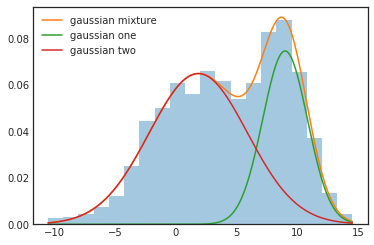

In [104]:
# Find best Mixture Gaussian model
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

#Show mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();

In [119]:
for i in data:
    print (best_mix.pdf(i) - mix.pdf(i))
    #print "2 ->",Gaussian(9.0,1.8).pdf(i)

1.17037844694e-10
1.22465537711e-10
1.37425418267e-10
2.47631540273e-10
-8.30178911726e-11
1.81627768381e-11
-1.20990474584e-11
3.02104230521e-10
6.94112128885e-11
-2.40847043698e-10
-4.06427252964e-11
3.01492719679e-11
-2.96139633649e-10
1.20805136727e-10
-1.24622367981e-10
-2.1165533215e-10
8.29301904925e-12
3.03005176505e-10
6.25105384122e-11
-2.59733456964e-10
-3.12093684229e-10
7.6245558478e-11
1.07572659114e-10
-4.52025504701e-12
5.76894851334e-11
2.14392434361e-10
4.37306718615e-11
-2.82662629414e-10
1.30290292444e-10
2.17459883434e-10
-2.4013852018e-10
-1.84120774183e-12
-1.97004537683e-10
-2.24135688308e-11
1.80475495659e-11
-2.72546464564e-10
1.39422209888e-10
1.22309926076e-10
-3.10815075066e-10
-3.11837396183e-10
-3.52406714921e-11
-6.65314886517e-11
5.32404155484e-11
8.70140591525e-11
-2.95671855055e-10
1.39398000087e-10
1.14190663869e-10
1.24708979254e-10
1.39397139665e-10
1.38670311345e-10
1.59302272762e-10
1.18621848455e-10
8.6592864823e-11
-1.91759943428e-11
1.29551341

In [113]:
for i in da

4.317081805628529

In [121]:
a=0
b=0
for i in data:
    a=a+best_mix.pdf(i)
    b=b+mix.pdf(i)
print (a,b)

(88.9740130622934, 88.97401305896119)


In [122]:
np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*2, self.N)

3.3322038461847114e-09

In [55]:
np.random.dirichlet([10,6,8,8,6], size=3)

array([[0.20397339, 0.21019657, 0.23683108, 0.13872367, 0.2102753 ],
       [0.24867117, 0.20010451, 0.19877645, 0.15330221, 0.19914565],
       [0.31951954, 0.04780208, 0.23039076, 0.25090235, 0.15138527]])

In [96]:
c=np.random.normal(1, 1, 100)

In [95]:
for i in c:
    print np.random.normal(i,1,1)[0]

0.39838394889068474
0.05313497008113392
0.0054144375390897045
0.1263471223831325
0.3558589150503621
0.3822302481176746
0.3984901287463662
0.2224225130988574
0.3743411198520928
0.021309614398358177
0.3447412561792398
0.3983460466912557
0.1851876677642082
0.14002006500251224
0.17181154707942686
0.03633808567697923
0.38951913830065577
0.14923288365278725
0.34135240875802497
0.28270099091650347
0.33432748065740137
0.00042952412133435123
0.07116832525004325
0.36044989451140613
0.3254778193440906
0.2622172244832916
0.1414701666008152
0.06607002606652476
0.39622403163719255
0.14132917897957892
0.3059782052450226
0.3946783046774858
0.20552885188522144
0.08898049679232518
0.004072374155531271
0.1916511305924375
0.08625982634807992
0.3479905927980749
0.3009034203885578
0.3798184152556983
0.30599818881970886
0.22431615972296923
0.3757402108787461
0.357395353847639
0.39534958506468804
0.08936759106189598
0.36873095213468743
0.11126186318431375
0.28021080630539663
0.23936611235962135
0.006073854828

0.252163960264132
0.0031051913226620817
0.07671958096968698
0.24173164878304051
0.10079996469764572
0.39030366259649174
0.3508970268354714
0.3013293146015476
0.3982116080968778
0.18556565046094642
0.09436603973410043
0.3525787147213612
0.3677375799585849
0.33453531644605544
0.2977753565265153
0.39733172175023984
0.11118545196044027
0.33333669105393665
0.36689855122298826
0.12860437379439466
0.366265746541132
0.375623806210449
0.25640067880778283
0.36235820048749007
0.12948143908135068
0.13915681183970752
0.18547929451508585
0.08739655097955912
0.2806181808973947
0.3248941528242147
0.39666196568455603
0.3798236403510289
0.39218852899701007
0.39786393813659926
0.018233212524652383
0.35131637227746865
0.0681581654236122
0.2431511336327361
0.0091494557631598
0.38839187453550683
0.022653542162004835
0.33577923315866387
0.3403815963044918
0.2840483039529845
0.362738406084929
0.144412298241357
0.2732802698555373
0.39055917328547785
0.13223493372523495
0.3198615240898758
0.10118928475288745
0.

0.3148754861855181
0.24036657933608052
0.3856677335031718
0.2598280191160151
0.26602688857737483
0.3142523510923806
0.3877548759482674
0.30663404803246824
0.3779438148085508
0.013998058883986069
0.3966702780520941
0.3494849012776305
0.36591266681543483
0.15069568723146592
0.14912613361506757
0.22466402986914505
0.20425059853178318
0.3900732691025694
0.07295953527001128
0.08384351462861307
0.2758634343669197
0.0868701867544671
0.39231214609932946
0.3203154306892455
